In [1]:
import pybullet as p
import numpy as np
import json
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import time

sys.path.append("../")
from env.ycb_scene import SimulatedYCBEnv
from utils.utils import *
from utils.planner import GraspPlanner

pybullet build time: May 20 2022 19:44:17


# Use slidebar to control the robot

In [2]:
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join("../object_index", 'contact_plane_object.json')   # 此json檔可以自己改
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['mug']     #只取json檔中的"test"
file_dir = [f[:-5] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)      #597

#ycb scene 中的 init 可以定義target_fixed, true代表target object不會自由落下 (第一次呼叫cabinet設定即可)
state = env.slidebar_cabinet(save=False, enforce_face_target=True)  

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 525.147.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 525.147.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
numActiveThreads = 0
stopping threads
destroy semaphore
semaphore destroyed
Thread with taskId 0 exiting
Thread TERMINATED
destroy main semaphore
main semaphore destroye

: 

: 

In [ ]:
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join("object_index", 'contact_plane_object.json')   # 此json檔可以自己改
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['tomato']     #只取json檔中的"test"
file_dir = [f[:-5] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)      #597

#ycb scene 中的 init 可以定義target_fixed, true代表target object不會自由落下 (第一次呼叫cabinet設定即可)
state = env.cabinet(save=False, enforce_face_target=True)  

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 525.147.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 525.147.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
numActiveThreads = 0
stopping threads
destroy semaphore
semaphore destroyed
Thread with taskId 0 exiting
Thread TERMINATED
destroy main semaphore
main semaphore destroye

### 重置桌上物體 (pile就不需要scene checker)

In [ ]:
num_object = 1
if_stack = False
single_release = True    # true為以自己設定的角度放在桌上; false就是pack放在桌上
state = env.cabinet(save=False, reset_free=True, num_object=num_object, if_stack=if_stack, single_release=single_release)

single_release： True
>>>> target name: 005_tomato_soup_can_1.0


#  get the multiview pcd (3個角度)


In [ ]:
placed_obj = {}   # define a dictionary
print(env.placed_objects)

placed_idx = np.where(np.array(env.placed_objects))[0]   # np.where有兩種用法, 一種為condition, 一種為此的用法
print(placed_idx)
# print(env.obj_indexes)   # all object name in dict
placed_name = np.array(env.obj_indexes)[placed_idx]
for i in range(num_object):
    placed_obj[placed_idx[i]] = placed_name[i]
print(placed_obj)    # only on table obj name
print(placed_name[0])

[True, False, False]
[0]
{0: '005_tomato_soup_can_1.0'}
005_tomato_soup_can_1.0


In [ ]:
env.draw_ef_coordinate(env._get_ef_pose(mat=True)@ env._get_target_relative_pose(option = 'ef'), 0)
env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)

In [ ]:
env.clean_debug_line()

In [ ]:
from utils.planner import GraspPlanner
planner = GraspPlanner()

def expert_plan(goal_pose, world=False, visual=False):
    if world:
        pos, orn = env._get_ef_pose()
        ef_pose_list = [*pos, *orn]
    else:
        ef_pose_list = [0, 0, 0, 0, 0, 0, 1]
    goal_pos = [*goal_pose[:3], *ros_quat(goal_pose[3:])]

    solver = planner.plan(ef_pose_list, goal_pos)
    if visual:
        path_visulization(solver)
    path = solver.getSolutionPath().getStates()
    planer_path = []
    for i in range(len(path)):
        waypoint = path[i]
        rot = waypoint.rotation()
        action = [waypoint.getX(), waypoint.getY(), waypoint.getZ(), rot.w, rot.x, rot.y, rot.z]
        planer_path.append(action)

    return planer_path

def path_visulization(ss):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    x = []
    y = []
    z = []
    for i in range(len(ss.getSolutionPath().getStates())):
        state = ss.getSolutionPath().getStates()[i]
        x.append(state.getX())
        y.append(state.getY())
        z.append(state.getZ())
    ax.plot(x, y, z, color='gray', label='Curve')

    ax.scatter(x, y, z, c=z, cmap='jet', label='Points')
    plt.show()

In [ ]:
init_ef_mat = np.array([[-1.98785608e-01,  7.23231525e-01,  6.61377686e-01,  1.06898375e-01],
                        [9.80042993e-01,  1.46612626e-01,  1.34240345e-01, -9.29623842e-02],
                        [1.20530092e-04,  6.74863616e-01, -7.37942468e-01, -2.43949398e-01],
                        [0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

left_view_ef_mat = np.array([[ 0.98757027,  0.02243495,  0.15556875,  0.45691898],
                            [ 0.14573556, -0.501431,   -0.85283533,  0.36891946],
                            [ 0.05887368,  0.86490672, -0.49846791, -0.33324587],
                            [ 0.,          0.,          0.,          1.]])

right_view_ef_mat = np.array([[ 0.98691477, -0.16087768,  0.010845,    0.46446365],
                            [-0.10023915, -0.55945926,  0.82277424, -0.28816143],
                            [-0.12629867, -0.81309514, -0.56826485, -0.19399673],
                            [ 0.,          0.,          0.,          1.]])


Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 0.24 in 13 iterations (14 vertices in the graph)
RRTstar found solution of path length 0.2403 with an optimization objective value of 0.2403Info:    RRTstar: Created 1037 new states. Checked 538203 rewire options. 1 goal states in tree. Final solution cost 0.240

Interpolate Path length to 20


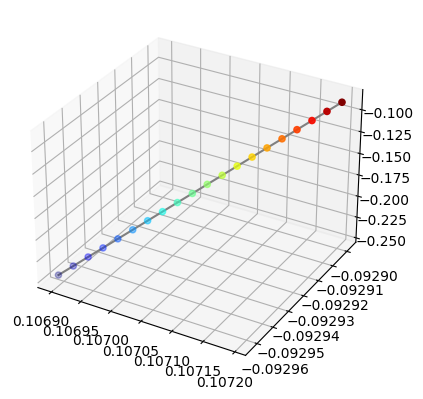

In [ ]:
env._panda.reset()
END_POINT = init_ef_mat
# env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)
plan = expert_plan(pack_pose(END_POINT), world=True, visual=True)
for i in range(len(plan)):
    # Set Target position with world frame based coordinate
    next_pos = plan[i]
    jointPoses = env._panda.solveInverseKinematics(next_pos[:3], ros_quat(next_pos[3:]))
    jointPoses[6] = 0.
    jointPoses = jointPoses[:7].copy()
    obs = env.step(jointPoses, config=True, repeat=200)[0]

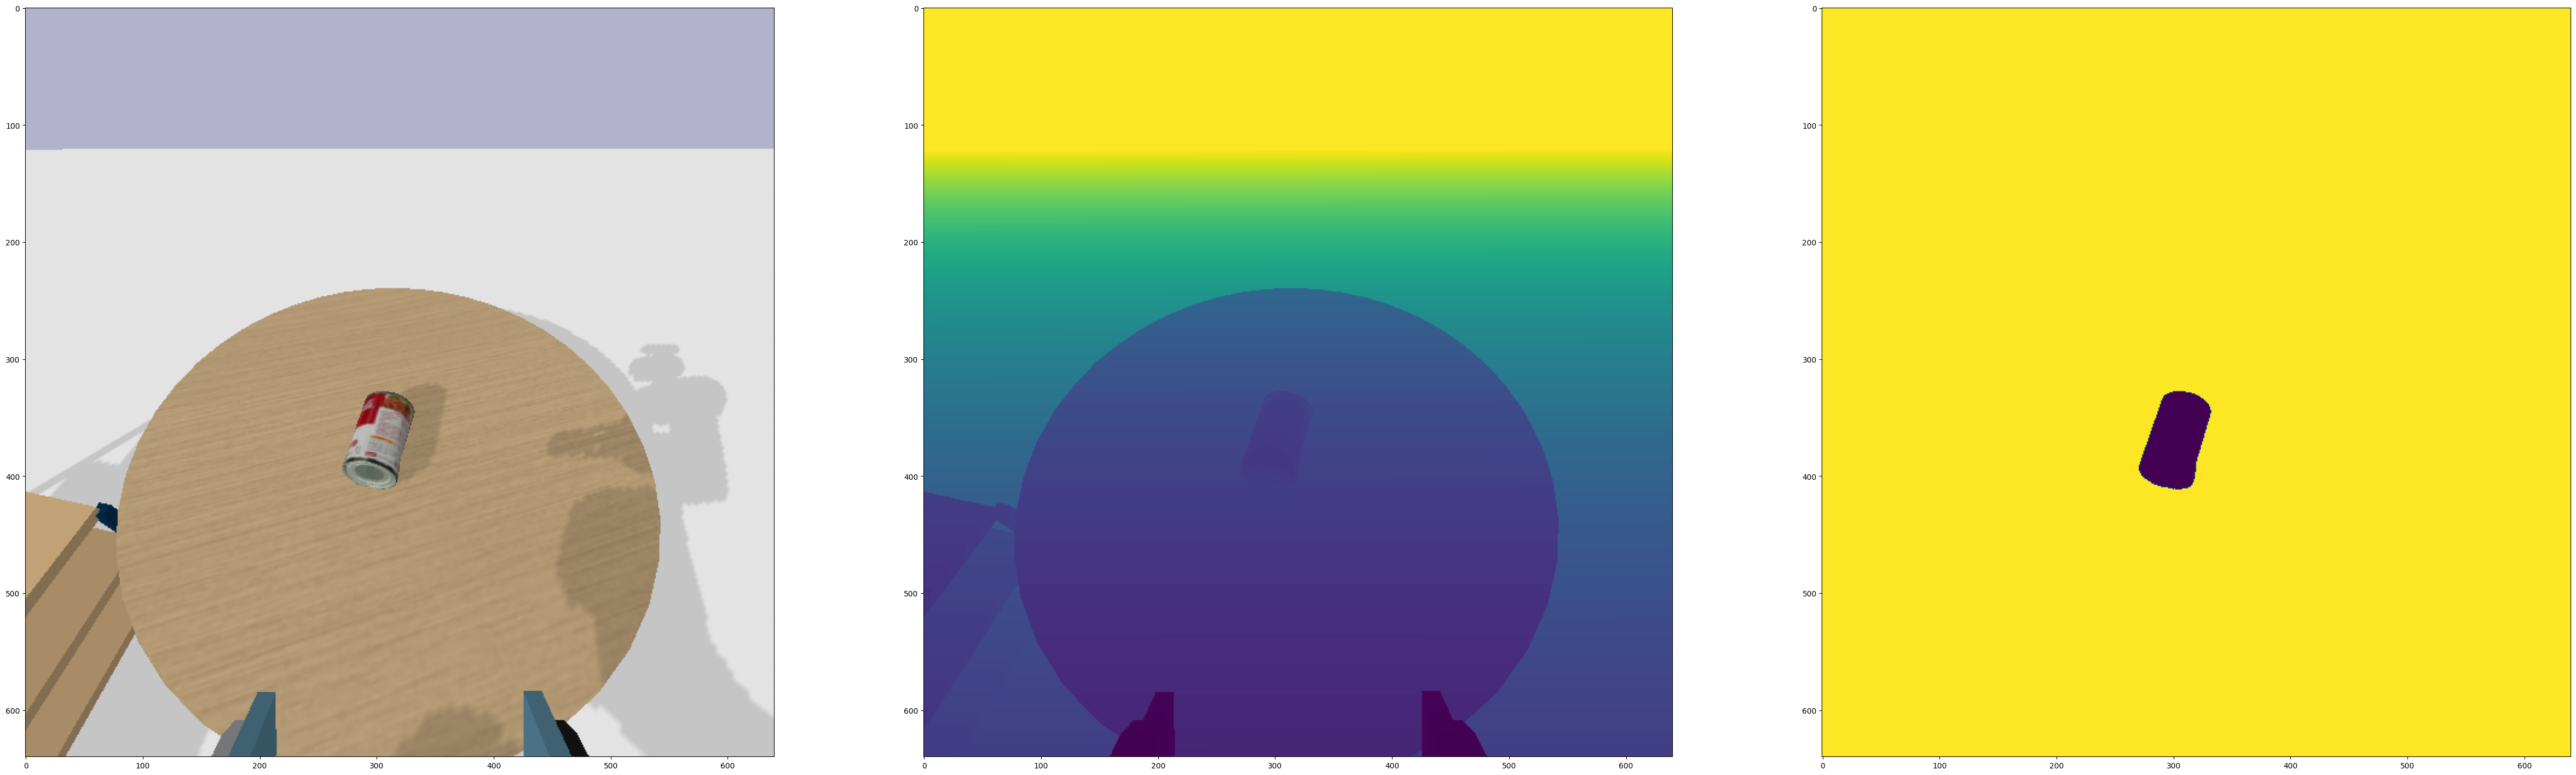

True

In [ ]:
obs, _, _, _, _ = env._get_observation()
fig=plt.figure(figsize=(60, 60))
fig.add_subplot(1, 3, 1)
plt.imshow(obs[1][:3].T) # RGB

fig.add_subplot(1, 3, 2)
plt.imshow(obs[1][3].T) # Depth
A = obs[1][3].T

fig.add_subplot(1, 3, 3)
plt.imshow(obs[1][4].T) # Mask
plt.show()

# save the rgb/depth/seg image
rgb = cv2.cvtColor(obs[1][:3].T, cv2.COLOR_BGR2RGB)
cv2.imwrite('./multiview_data/color0_{}.png'.format(placed_name[0]), rgb*255)

depth = obs[1][3].T
np.save('./multiview_data/depth0_{}.npy'.format(placed_name[0]), depth)  # 單位為公尺

mask = obs[1][4].T
ones = np.ones(shape = (640, 640))
mask = ones - mask
cv2.imwrite('./multiview_data/mask0_{}.png'.format(placed_name[0]), mask)


In [ ]:
table_ef_pose = env._get_ef_pose(mat=True)
print(table_ef_pose)
# env.draw_ef_coordinate(env._get_ef_pose(mat=True)@ env._get_target_relative_pose(option = 'ef'), 0)
print(env._get_target_relative_pose(option = 'ef'))

[[-1.98593253e-01  7.24638375e-01  6.59893889e-01  1.06875539e-01]
 [ 9.80081836e-01  1.46447112e-01  1.34137387e-01 -9.28994864e-02]
 [ 5.61543639e-04  6.73388794e-01 -7.39288318e-01 -2.42741913e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-0.00200983  0.97766915 -0.21014053  0.0207369 ]
 [-0.66811468  0.15504404  0.72772532  0.05250223]
 [ 0.7440556   0.14186058  0.65288348  0.4875526 ]
 [ 0.          0.          0.          1.        ]]


## get the enviroment pcd

Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 1.47 in 7 iterations (8 vertices in the graph)
RRTstar found solution of path length 1.4747 with an optimization objective value of 1.4747Info:    RRTstar: Created 1012 new states. Checked 512578 rewire options. 1 goal states in tree. Final solution cost 1.475

Interpolate Path length to 20


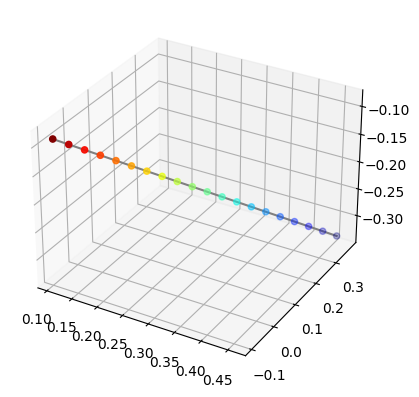

In [ ]:
env._panda.reset()
END_POINT = left_view_ef_mat
# env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)
plan = expert_plan(pack_pose(END_POINT), world=True, visual=True)
for i in range(len(plan)):
    # Set Target position with world frame based coordinate
    next_pos = plan[i]
    jointPoses = env._panda.solveInverseKinematics(next_pos[:3], ros_quat(next_pos[3:]))
    jointPoses[6] = 0.
    jointPoses = jointPoses[:7].copy()
    obs = env.step(jointPoses, config=True, repeat=200)[0]

In [ ]:
environment_ef_pose = env._get_ef_pose(mat=True)
print(environment_ef_pose)

[[ 0.98578702  0.03135664  0.16504759  0.45414671]
 [ 0.15817836 -0.50422183 -0.84896405  0.36529341]
 [ 0.05659994  0.8630047  -0.50201527 -0.330769  ]
 [ 0.          0.          0.          1.        ]]


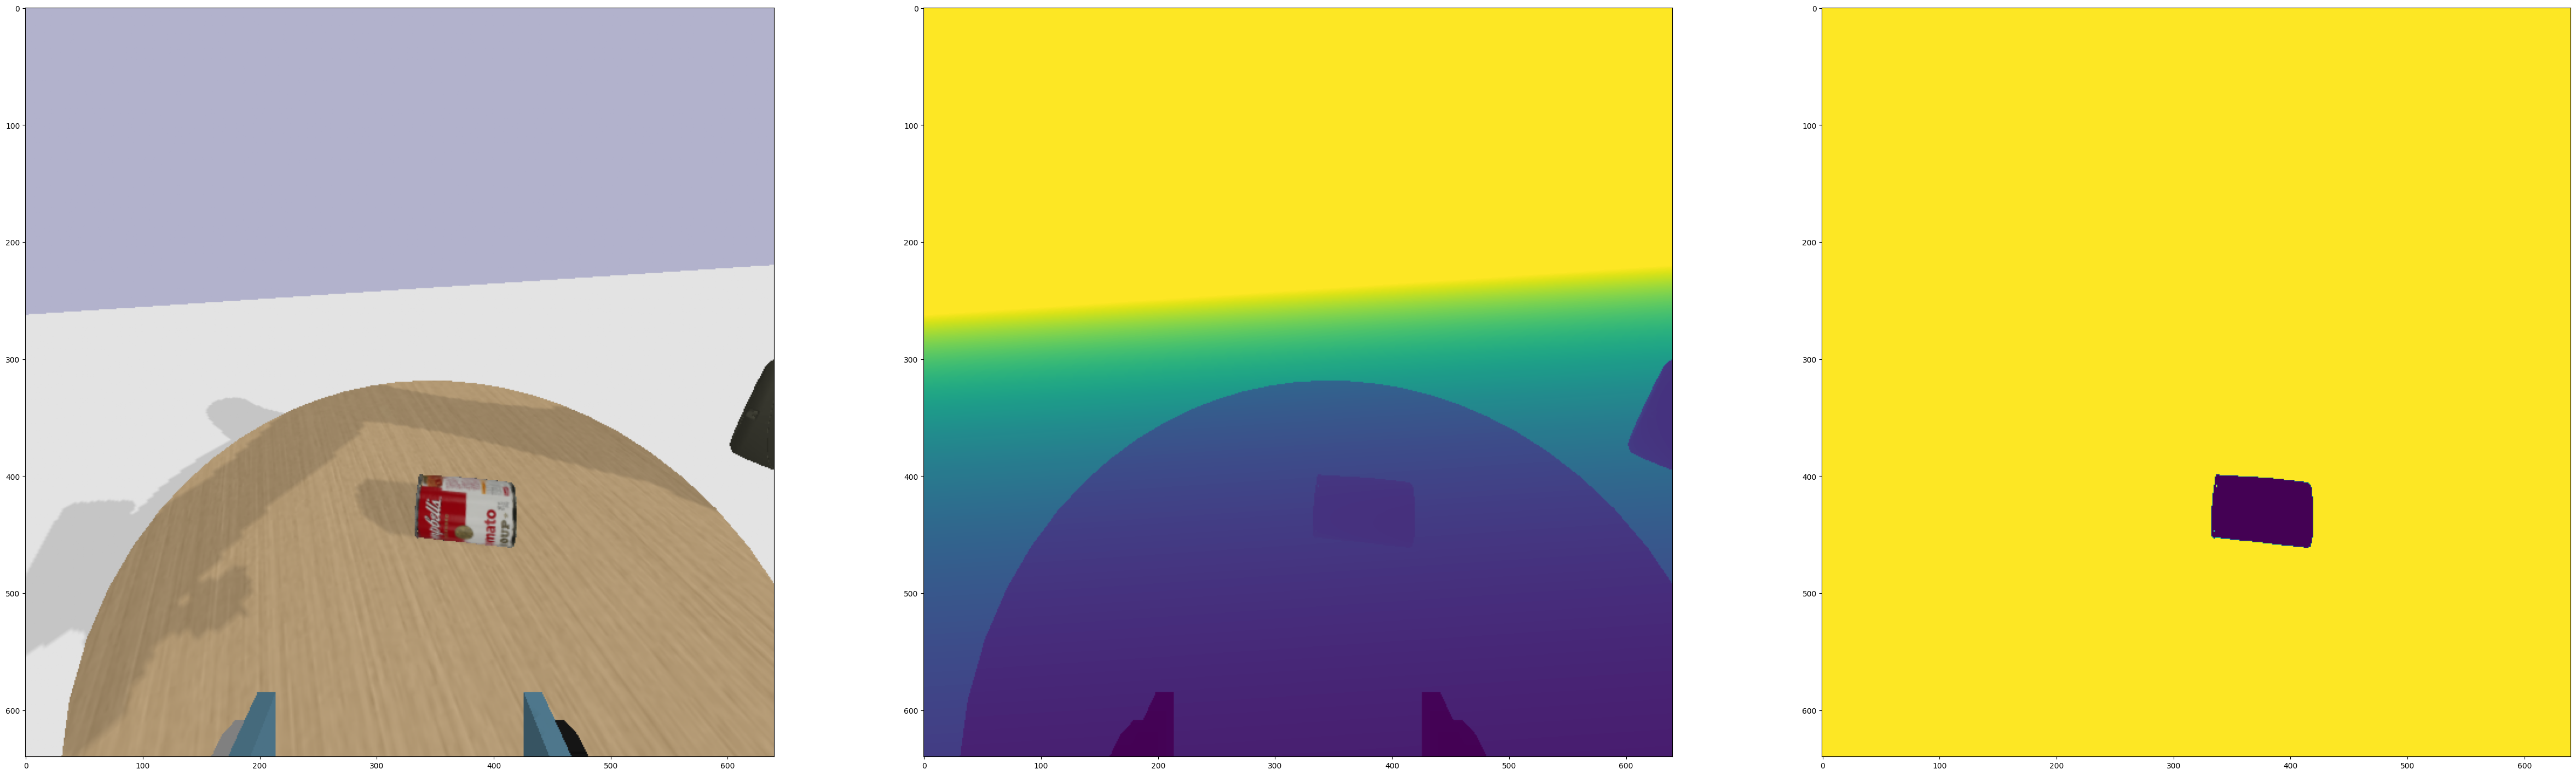

True

In [ ]:
obs, _, _, _, _ = env._get_observation()
fig=plt.figure(figsize=(60, 60))
fig.add_subplot(1, 3, 1)
plt.imshow(obs[1][:3].T) # RGB

fig.add_subplot(1, 3, 2)
plt.imshow(obs[1][3].T) # Depth
A = obs[1][3].T

fig.add_subplot(1, 3, 3)
plt.imshow(obs[1][4].T) # Mask
plt.show()

# save the rgb/depth/seg image
rgb = cv2.cvtColor(obs[1][:3].T, cv2.COLOR_BGR2RGB)
cv2.imwrite('./multiview_data/color1_{}.png'.format(placed_name[0]), rgb*255)

depth = obs[1][3].T
np.save('./multiview_data/depth1_{}.npy'.format(placed_name[0]), depth)  # 單位為公尺

mask = obs[1][4].T
ones = np.ones(shape = (640, 640))
mask = ones - mask
cv2.imwrite('./multiview_data/mask1_{}.png'.format(placed_name[0]), mask)


Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 1.59 in 10 iterations (11 vertices in the graph)
RRTstar found solution of path length 1.5893 with an optimization objective value of 1.5893Info:    RRTstar: Created 991 new states. Checked 491536 rewire options. 1 goal states in tree. Final solution cost 1.589

Interpolate Path length to 20


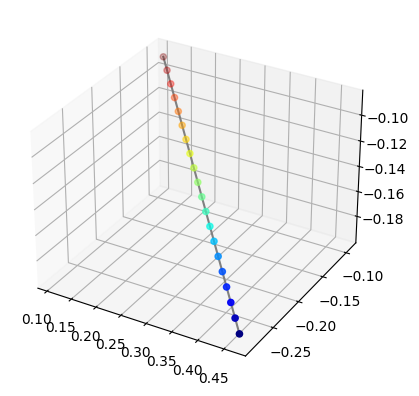

In [ ]:
env._panda.reset()
END_POINT = right_view_ef_mat
# env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)
plan = expert_plan(pack_pose(END_POINT), world=True, visual=True)
for i in range(len(plan)):
    # Set Target position with world frame based coordinate
    next_pos = plan[i]
    jointPoses = env._panda.solveInverseKinematics(next_pos[:3], ros_quat(next_pos[3:]))
    jointPoses[6] = 0.
    jointPoses = jointPoses[:7].copy()
    obs = env.step(jointPoses, config=True, repeat=200)[0]

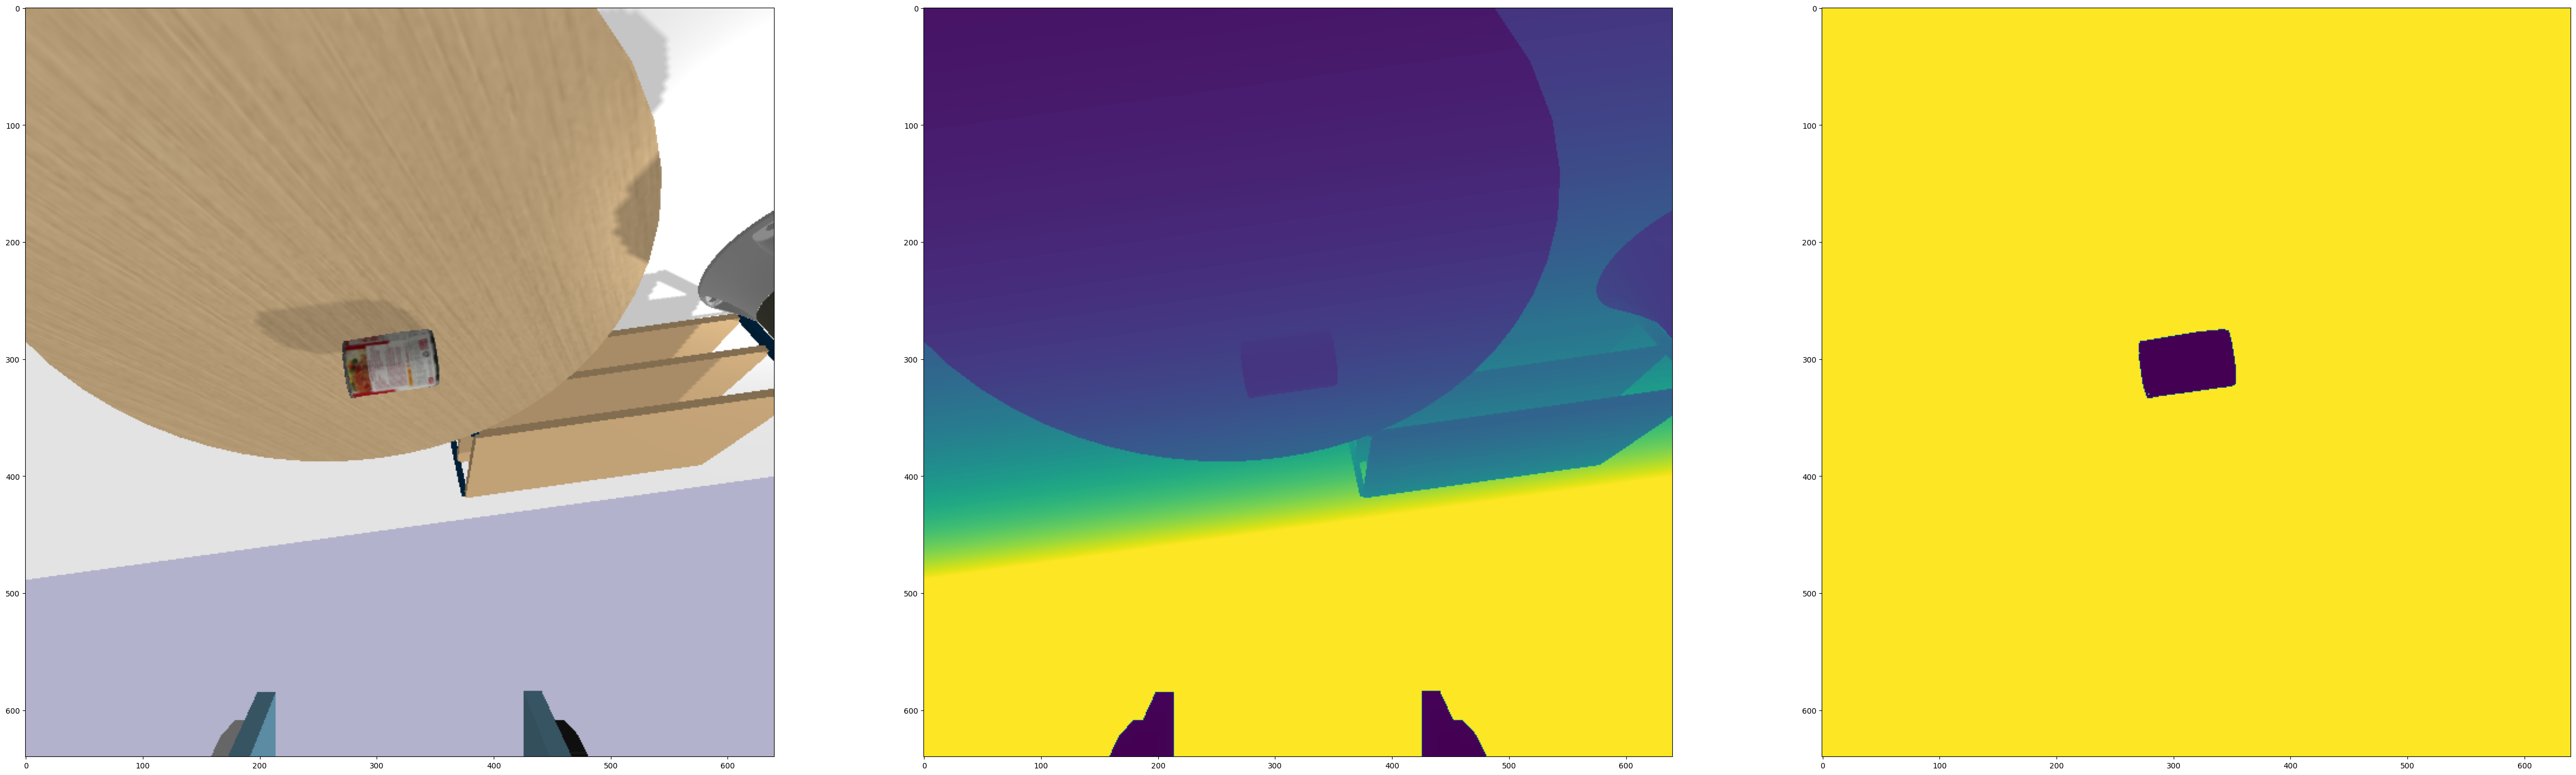

True

In [ ]:
obs, _, _, _, _ = env._get_observation()
fig=plt.figure(figsize=(60, 60))
fig.add_subplot(1, 3, 1)
plt.imshow(obs[1][:3].T) # RGB

fig.add_subplot(1, 3, 2)
plt.imshow(obs[1][3].T) # Depth
A = obs[1][3].T

fig.add_subplot(1, 3, 3)
plt.imshow(obs[1][4].T) # Mask
plt.show()

# save the rgb/depth/seg image
rgb = cv2.cvtColor(obs[1][:3].T, cv2.COLOR_BGR2RGB)
cv2.imwrite('./multiview_data/color2_{}.png'.format(placed_name[0]), rgb*255)

depth = obs[1][3].T
np.save('./multiview_data/depth2_{}.npy'.format(placed_name[0]), depth)  # 單位為公尺

mask = obs[1][4].T
ones = np.ones(shape = (640, 640))
mask = ones - mask
cv2.imwrite('./multiview_data/mask2_{}.png'.format(placed_name[0]), mask)


### get the rgbd data that I save before and merge them from multiview

In [ ]:
### 將open3d下的點雲轉到world座標
world_frame_pose = np.array([[ 1.,    0.,    0.,   -0.05],
                            [ 0.,    1.,    0.,    0.  ],
                            [ 0.,    0.,    1.,   -0.65],
                            [ 0.,    0.,    0.,    1.  ]])

environment_ef_pose = np.array([[-9.82531234e-01, -1.56505464e-01, -1.00689692e-01,  9.29813683e-02],
                                [-1.86097625e-01,  8.26932506e-01,  5.30613140e-01,  1.05557159e-01],
                                [ 2.19723435e-04,  5.40082096e-01, -8.41612311e-01, -8.86108577e-02],
                                [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# 獲取第一個點雲有往下移一點和initial pose不一樣
init_ef_mat = np.array([[-1.98785608e-01,  7.23231525e-01,  6.61377686e-01,  1.06898375e-01],    
                        [9.80042993e-01,  1.46612626e-01,  1.34240345e-01, -9.29623842e-02],
                        [1.20530092e-04,  6.74863616e-01, -7.37942468e-01, -2.43949398e-01],
                        [0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

left_view_ef_mat = np.array([[ 0.98757027,  0.02243495,  0.15556875,  0.45691898],
                            [ 0.14573556, -0.501431,   -0.85283533,  0.36891946],
                            [ 0.05887368,  0.86490672, -0.49846791, -0.33324587],
                            [ 0.,          0.,          0.,          1.]])

right_view_ef_mat = np.array([[ 0.98691477, -0.16087768,  0.010845,    0.46446365],
                            [-0.10023915, -0.55945926,  0.82277424, -0.28816143],
                            [-0.12629867, -0.81309514, -0.56826485, -0.19399673],
                            [ 0.,          0.,          0.,          1.]])


cam_offset = np.eye(4)
# 先轉到pybullet座標後再往上移動0.13變相機座標
cam_offset[:3, 3] = (np.array([0., 0.1186, -0.0191344123493]))
# open3d 和 pybullet中的coordinate要對z旋轉180度才會一樣
cam_offset[:3, :3] = np.array([[-1, 0, 0],
                                [0, -1, 0],
                                [0, 0, 1]])

intrinsic_matrix = np.array([[320, 0, 320],
                             [0, 320, 320],
                             [0, 0, 1]])

### 轉換關係
origin_camera2world = cam_offset@ np.linalg.inv(init_ef_mat)@ world_frame_pose
left_camera2world = cam_offset@ np.linalg.inv(left_view_ef_mat)@ world_frame_pose
right_camera2world = cam_offset@ np.linalg.inv(right_view_ef_mat)@ world_frame_pose

In [ ]:
import os
from PIL import Image
import numpy as np
import open3d as o3d

# 定義文件名和物體列表
objects = [placed_name[0]]
views_dict = {"origin": 0, "left": 1, "right": 2}

# 創建 2 維列表來存儲圖像、深度和遮罩數據
rgb_list = []
depth_list = []
mask_list = []

def load_data(object_name, view_index):
    '''
    return type: numpy array(rgb, depth, mask)
    '''
    rgb_filename = f'./multiview_data/color{view_index}_{object_name}.png'
    depth_filename = f'./multiview_data/depth{view_index}_{object_name}.npy'
    mask_filename = f'./multiview_data/mask{view_index}_{object_name}.png'

    rgb = Image.open(rgb_filename)
    depth = np.load(depth_filename)
    mask = Image.open(mask_filename)

    rgb = np.array(rgb)
    rgb = rgb/255
    depth = depth
    mask = np.array(mask)

    return rgb, depth, mask

def create_point_cloud_and_camera(rgb, depth, mask, camera_transform, color=None):
    '''
    create the point cloud by rgbd data
    then, transfrom the numpy array to open3d point cloud
    return type: o3d.geometry.PointCloud
    '''
    pc_full, pc_segments, pc_colors = extract_point_clouds(depth=depth, K=intrinsic_matrix, segmap=mask, rgb=rgb, z_range=[0.2, 0.6])

    pc_full_pcd = o3d.geometry.PointCloud()
    pc_full_pcd.points = o3d.utility.Vector3dVector(pc_full)
    pc_full_pcd.colors = o3d.utility.Vector3dVector(pc_colors)

    pc_segments_pcd = o3d.geometry.PointCloud()
    pc_segments_pcd.points = o3d.utility.Vector3dVector(pc_segments[1])
    pc_segments_pcd.colors = o3d.utility.Vector3dVector(pc_colors)
    
    
    pc_full_pcd.transform(camera_transform)
    pc_segments_pcd.transform(camera_transform)
    if color is not None:
        pc_full_pcd.paint_uniform_color(color)
        pc_segments_pcd.paint_uniform_color(color)

    return pc_full_pcd, pc_segments_pcd

for obj in objects:
    obj_rgb = []
    obj_depth = []
    obj_mask = []

    for view_name, view_index in views_dict.items():
        rgb, depth, mask = load_data(obj, view_index)
        obj_rgb.append(rgb)
        obj_depth.append(depth)
        obj_mask.append(mask)

    rgb_list.append(obj_rgb)
    depth_list.append(obj_depth)
    mask_list.append(obj_mask)

target_object = 0

# Define intrinsic_matrix, placed_name, origin_camera2world, and other necessary variables.



for index in range(3):
    rgb, depth, mask = rgb_list[target_object][index], depth_list[target_object][index], mask_list[target_object][index]
    
    if index == 0:
        camera_transform = np.linalg.inv(origin_camera2world)
        color = None
        pc_full_pcd_0, pc_segments_pcd_0 = create_point_cloud_and_camera(rgb, depth, mask, camera_transform, color)
    elif index == 1:
        camera_transform = np.linalg.inv(left_camera2world)
        color = None
        pc_full_pcd_1, pc_segments_pcd_1 = create_point_cloud_and_camera(rgb, depth, mask, camera_transform, color)

    else:
        camera_transform = np.linalg.inv(right_camera2world)
        color = None
        pc_full_pcd_2, pc_segments_pcd_2 = create_point_cloud_and_camera(rgb, depth, mask, camera_transform, color)
    

robot_base = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
camera0 = getCamera(np.linalg.inv(origin_camera2world), length=0.1, color=[1, 0, 0])
camera1 = getCamera(np.linalg.inv(left_camera2world), length=0.1, color=[0, 1, 0])
camera2 = getCamera(np.linalg.inv(right_camera2world), length=0.1, color=[0, 0, 1])

camera = [*camera0, *camera1, *camera2]
o3d.visualization.draw_geometries([*camera, robot_base, pc_segments_pcd_0, pc_segments_pcd_1, pc_segments_pcd_2])
o3d.visualization.draw_geometries([*camera, robot_base, pc_full_pcd_0, pc_full_pcd_1, pc_full_pcd_2])


KeyboardInterrupt: 

In [ ]:
import copy
### combine the pcd
# combine the point cloud pc_init , pc_left, pc_right
def get_combine_pcd(pc_init, pc_left, pc_right):
    '''
    return o3d.geometry.PointCloud
    '''
    pc_combine = copy.deepcopy(pc_init)
    pc_combine.points = o3d.utility.Vector3dVector(np.vstack((pc_init.points, pc_left.points, pc_right.points)))
    return pc_combine

pc_segments_combine_pcd = get_combine_pcd(pc_segments_pcd_0, pc_segments_pcd_1, pc_segments_pcd_2)
pc_full_combine_pcd = get_combine_pcd(pc_full_pcd_0, pc_full_pcd_1, pc_full_pcd_2)

# transform the point cloud to the origin_camera2world
pc_segments_combine_pcd.transform(origin_camera2world)
pc_full_combine_pcd.transform(origin_camera2world)

# save the combine point cloud as npy
pc_segments_combine = np.asarray(pc_segments_combine_pcd.points)
pc_full_combine = np.asarray(pc_full_combine_pcd.points)

np.save('./multiview_data/pc_segments_combine.npy', pc_segments_combine)
np.save('./multiview_data/pc_full_combine.npy', pc_full_combine)

### add the noise on pcd

In [ ]:
def augment_depth_realsense(depth, depth_adjustment=0, coefficient_scale=1):
    # augment depth according to the empirical realsense paper
    # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8768489&tag=1

    # print("ln250 augment depths")
    # print(np.max(depth))
    # print(np.min(depth))
    sigma = .001063*coefficient_scale + coefficient_scale*.0007278*(depth-depth_adjustment) \
            + coefficient_scale*.003949*(depth-depth_adjustment)**2
    new_depth = np.random.normal(loc=depth, scale=sigma)

    return new_depth
# apply realsense noise
# use augment_depth_realsense to augment the pc_combine_np
pc_full_combine_noise = augment_depth_realsense(pc_full_combine, coefficient_scale=1)
print(pc_full_combine_noise.shape)

pc_segments_combine_noise = augment_depth_realsense(pc_segments_combine, coefficient_scale=1)
print(pc_segments_combine_noise.shape)

# save the augmented point cloud as npy
np.save('./multiview_data/pc_full_combine_noise.npy', pc_full_combine_noise)
np.save('./multiview_data/pc_segments_combine_noise.npy', pc_segments_combine_noise)
# use open3d to visualize the augmented point cloud
pc_full_combine_noise_pcd = o3d.geometry.PointCloud()
pc_full_combine_noise_pcd.points = o3d.utility.Vector3dVector(pc_full_combine_noise)
pc_full_combine_noise_pcd.paint_uniform_color([0, 0, 1])
pc_full_combine_noise_pcd.transform(np.linalg.inv(origin_camera2world))
o3d.visualization.draw_geometries([pc_full_combine_noise_pcd, robot_base, *camera])
### downsample the pcd
downsampled_pcd = pc_full_combine_noise_pcd.voxel_down_sample(voxel_size=0.005)
print(np.asarray(downsampled_pcd.points).shape)
downsampled_pcd.paint_uniform_color([1, 0, 0])
# o3d.visualization.draw_geometries([downsampled_pcd, robot_base])

(534873, 3)
(22947, 3)
(57984, 3)


PointCloud with 57984 points.

: 

# Finish get the multiview

## get the obb

In [ ]:
# copy pc_segments_combine_noise
pc_segments_combine_noise_copy = copy.deepcopy(pc_segments_combine_noise)
# transfrom to pcd
pc_segments_combine_noise_copy_pcd = o3d.geometry.PointCloud()
pc_segments_combine_noise_copy_pcd.points = o3d.utility.Vector3dVector(pc_segments_combine_noise_copy)
pc_segments_combine_noise_copy_pcd.paint_uniform_color([1, 1, 1])

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])

# get the obb
obb = pc_segments_combine_noise_copy_pcd.get_oriented_bounding_box()
obb.color = (1, 0, 0)

o3d.visualization.draw_geometries([pc_segments_combine_noise_copy_pcd, obb])

In [ ]:
env._panda.reset()
env.clean_debug_line()

In [ ]:
# obs, joint_pos, camera_info, pose_info, _ = env._get_observation(raw_data=True)
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(obs[0][:3].T)
# axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1000, origin=[0, 0, 0])
# o3d.visualization.draw_geometries([pcd]+ [axis_pcd])

# 疊合3張圖

In [ ]:
# env.draw_ef_coordinate(env._get_world_frame_pose(mat=True), 0)
# env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)
# print(env._get_world_frame_pose(mat=True))
# print(env._get_ef_pose(mat=True))
# #因為ef pose之類的都是根據上方的world frame來的, 若要以world frame做轉換必須要平移後才是world frame

In [ ]:
import random
import time
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import os
import copy
import sys

import os
from utils.utils import *


In [ ]:
### 將open3d下的點雲轉到world座標
world_frame_pose = np.array([[ 1.,    0.,    0.,   -0.05],
                            [ 0.,    1.,    0.,    0.  ],
                            [ 0.,    0.,    1.,   -0.65],
                            [ 0.,    0.,    0.,    1.  ]])

environment_ef_pose = np.array([[-9.82531234e-01, -1.56505464e-01, -1.00689692e-01,  9.29813683e-02],
                                [-1.86097625e-01,  8.26932506e-01,  5.30613140e-01,  1.05557159e-01],
                                [ 2.19723435e-04,  5.40082096e-01, -8.41612311e-01, -8.86108577e-02],
                                [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# 獲取第一個點雲有往下移一點和initial pose不一樣
init_ef_mat = np.array([[-1.98785608e-01,  7.23231525e-01,  6.61377686e-01,  1.06898375e-01],    
                        [9.80042993e-01,  1.46612626e-01,  1.34240345e-01, -9.29623842e-02],
                        [1.20530092e-04,  6.74863616e-01, -7.37942468e-01, -2.43949398e-01],
                        [0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

left_view_ef_mat = np.array([[ 0.98757027,  0.02243495,  0.15556875,  0.45691898],
                            [ 0.14573556, -0.501431,   -0.85283533,  0.36891946],
                            [ 0.05887368,  0.86490672, -0.49846791, -0.33324587],
                            [ 0.,          0.,          0.,          1.]])

right_view_ef_mat = np.array([[ 0.98691477, -0.16087768,  0.010845,    0.46446365],
                            [-0.10023915, -0.55945926,  0.82277424, -0.28816143],
                            [-0.12629867, -0.81309514, -0.56826485, -0.19399673],
                            [ 0.,          0.,          0.,          1.]])


cam_offset = np.eye(4)
# 先轉到pybullet座標後再往上移動0.13變相機座標
cam_offset[:3, 3] = (np.array([0., 0.1186, -0.0191344123493]))
# open3d 和 pybullet中的coordinate要對z旋轉180度才會一樣
cam_offset[:3, :3] = np.array([[-1, 0, 0],
                                [0, -1, 0],
                                [0, 0, 1]])

intrinsic_matrix = np.array([[320, 0, 320],
                             [0, 320, 320],
                             [0, 0, 1]])

### 轉換關係
origin_camera2world = cam_offset@ np.linalg.inv(init_ef_mat)@ world_frame_pose
left_camera2world = cam_offset@ np.linalg.inv(left_view_ef_mat)@ world_frame_pose
right_camera2world = cam_offset@ np.linalg.inv(right_view_ef_mat)@ world_frame_pose

In [ ]:
import os
from PIL import Image
import numpy as np

# 定義文件名和物體列表
objects = ["003_cracker_box", "005_tomato_soup_can", "006_mustard_bottle", "019_pitcher_base", "021_bleach_cleanser", "024_bowl", "025_mug"]
views_dict = {"origin": 0, "left": 1, "right": 2}

# 創建 2 維列表來存儲圖像、深度和遮罩數據
rgb_list = []
depth_list = []
mask_list = []

for obj in objects:
    obj_rgb = []
    obj_depth = []
    obj_mask = []

    for view_name, view_index in views_dict.items():
        # filename_prefix = f'./multiview_data/color{view_name}_{obj}_1.0'
        rgb = Image.open(f'./multiview_data/color{view_index}_{obj}_1.0.png')
        depth = np.load(f'./multiview_data/depth{view_index}_{obj}_1.0.npy')
        mask = Image.open(f'./multiview_data/mask{view_index}_{obj}_1.0.png')

        obj_rgb.append(rgb)
        obj_depth.append(depth)
        obj_mask.append(mask)

    rgb_list.append(obj_rgb)
    depth_list.append(obj_depth)
    mask_list.append(obj_mask)


In [ ]:
target_object = 5
index = 0
rgb = np.array(rgb_list[target_object][index])
rgb = rgb/255
depth = depth_list[target_object][index]
mask = np.array(mask_list[target_object][index])
pc_full, pc_segments, pc_colors = extract_point_clouds(depth = depth,   K = intrinsic_matrix, segmap = mask, rgb = rgb, z_range = [0.2, 1.])

pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(pc_full)
pc.colors = o3d.utility.Vector3dVector(pc_colors)
# o3d.visualization.draw_geometries([pc, origin_frame])

pc_init = o3d.geometry.PointCloud()
pc_init.points = o3d.utility.Vector3dVector(pc_segments[1])
pc_init.transform(np.linalg.inv(origin_camera2world))
pc_init.paint_uniform_color([1, 0, 0])
camera0 = getCamera(np.linalg.inv(origin_camera2world), length=0.1, color=np.array([1, 0, 0]))

# o3d.visualization.draw_geometries([pc_init, origin_frame])
##################################################
index = 1
rgb = np.array(rgb_list[target_object][index])
rgb = rgb/255
depth = depth_list[target_object][index]
mask = np.array(mask_list[target_object][index])
pc_full, pc_segments, pc_colors = extract_point_clouds(depth = depth,   K = intrinsic_matrix, segmap = mask, rgb = rgb, z_range = [0.2, 1.])

pc_left = o3d.geometry.PointCloud()
pc_left.points = o3d.utility.Vector3dVector(pc_segments[1])
pc_left.transform(np.linalg.inv(left_camera2world))
pc_left.paint_uniform_color([0, 1, 0])
camera1 = getCamera(np.linalg.inv(left_camera2world), length=0.1, color=np.array([0, 1, 0]))
o3d.visualization.draw_geometries([pc_left, *camera1])

############################################################
index = 2
rgb = np.array(rgb_list[target_object][index])
rgb = rgb/255
depth = depth_list[target_object][index]
mask = np.array(mask_list[target_object][index])
pc_full, pc_segments, pc_colors = extract_point_clouds(depth = depth,   K = intrinsic_matrix, segmap = mask, rgb = rgb, z_range = [0.2, 1.])

pc_right = o3d.geometry.PointCloud()
pc_right.points = o3d.utility.Vector3dVector(pc_segments[1])
pc_right.transform(np.linalg.inv(right_camera2world))
pc_right.paint_uniform_color([0, 0, 1])
camera2 = getCamera(np.linalg.inv(right_camera2world), length=0.1, color=np.array([0, 0, 1]))
robot_base = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
camera = [*camera0, *camera1, *camera2]
o3d.visualization.draw_geometries([pc_init, pc_right, pc_left, robot_base, *camera])


IndexError: list index out of range

## combine the pcd and add the realsense noise on it

In [ ]:
### combine the pcd
# combine the point cloud pc_init , pc_left, pc_right
pc_combine = copy.deepcopy(pc_init)
pc_combine.points = o3d.utility.Vector3dVector(np.vstack((pc_init.points, pc_left.points, pc_right.points)))
# save the combine point cloud as npy
# pc_combine_np = np.asarray(pc_combine.points)
# np.save('./multiview_data/pc_combine.npy', pc_combine_np)
print(np.asarray(pc_combine.points).shape)
### add the noise on pcd
def augment_depth_realsense(depth, depth_adjustment=0, coefficient_scale=1):
    # augment depth according to the empirical realsense paper
    # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8768489&tag=1

    # print("ln250 augment depths")
    # print(np.max(depth))
    # print(np.min(depth))
    sigma = .001063*coefficient_scale + coefficient_scale*.0007278*(depth-depth_adjustment) \
            + coefficient_scale*.003949*(depth-depth_adjustment)**2
    new_depth = np.random.normal(loc=depth, scale=sigma)

    return new_depth
# apply realsense noise
# use augment_depth_realsense to augment the pc_combine_np
pc_combine_np = np.asarray(pc_combine.points)
new_depths = augment_depth_realsense(pc_combine_np, coefficient_scale=1)
print(new_depths.shape)
# save the augmented point cloud as npy
np.save('./multiview_data/pcd_combine_augmented.npy', new_depths)
# use open3d to visualize the augmented point cloud
pc_combine_augmented = o3d.geometry.PointCloud()
pc_combine_augmented.points = o3d.utility.Vector3dVector(new_depths)
pc_combine_augmented.paint_uniform_color([0, 0, 1])
o3d.visualization.draw_geometries([pc_combine_augmented, robot_base, *camera])
### downsample the pcd
downsampled_pcd = pc_combine_augmented.voxel_down_sample(voxel_size=0.005)
print(np.asarray(downsampled_pcd.points).shape)
downsampled_pcd.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([downsampled_pcd, robot_base])

(23825, 3)
(23825, 3)
(2843, 3)


### get the obb

In [ ]:
# use open3d obb to get bbox

obb = downsampled_pcd.get_oriented_bounding_box()
obb.color = (0, 1, 0)
# 可视化
origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05, origin=downsampled_pcd.get_center())

# o3d.visualization.draw_geometries([pcd, origin_frame])
o3d.visualization.draw_geometries([downsampled_pcd, obb])